In [26]:
import pykeen
import matplotlib.pyplot as plt
import numpy as np
from pykeen.pipeline import pipeline
from pykeen.models import predict
from pykeen.datasets import Nations, Countries
from pykeen.pipeline.plot_utils import plot_er
from pykeen.triples import TriplesFactory


In [2]:
# dataset = Countries()
dataset = Nations()


In [3]:
def entity_embedding_getter_TransE(model) -> pykeen.nn.Embedding:
    entity_representations_embedding = model.entity_representations[0]
    assert isinstance(entity_representations_embedding, pykeen.nn.Embedding)
    return entity_representations_embedding


def relation_embedding_getter_TransE(model) -> pykeen.nn.Embedding:
    relation_representations_embedding = model.relation_representations[0]
    assert isinstance(relation_representations_embedding, pykeen.nn.Embedding)
    return relation_representations_embedding


In [4]:
training = dataset.training
testing = dataset.testing
validation = dataset.validation

training


TriplesFactory(num_entities=14, num_relations=55, create_inverse_triples=False, num_triples=1592, path="/home/serveradmin/miniconda3/envs/my-pykeen/lib/python3.8/site-packages/pykeen/datasets/nations/train.txt")

In [19]:
results = pipeline(
    training=training,
    testing=testing,
    model='TransE',
    model_kwargs=dict(embedding_dim=20),
    optimizer_kwargs=dict(lr=0.01),
    training_kwargs=dict(num_epochs=128, use_tqdm_batch=False),
    evaluation_kwargs=dict(batch_size=32, use_tqdm=False),
    random_seed=1,
    device='gpu',
)


INFO:pykeen.pipeline.api:Using device: gpu


Training epochs on cpu:   0%|          | 0/128 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds


(<Figure size 1000x400 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>,
        <AxesSubplot: title={'center': 'Entity/Relation Plot using PCA'}>],
       dtype=object))

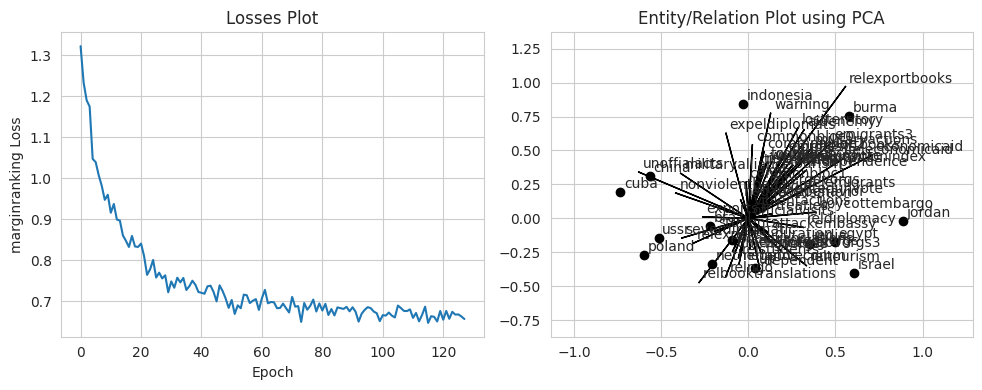

In [20]:
results.plot(
    er_kwargs=dict(
        plot_relations=True,
        entity_embedding_getter=entity_embedding_getter_TransE,
        relation_embedding_getter=relation_embedding_getter_TransE
    )
)

<AxesSubplot: title={'center': 'Entity/Relation Plot using PCA'}>

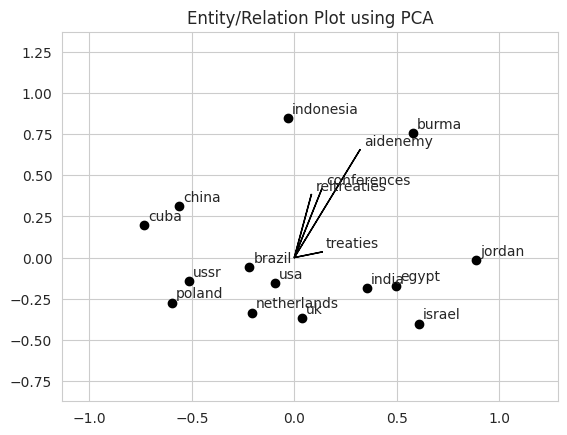

In [24]:
results.plot_er(
    plot_relations=True,
    relations={"reltreaties", "treaties", "conferences", "aidenemy"},
    entity_embedding_getter=entity_embedding_getter_TransE,
    relation_embedding_getter=relation_embedding_getter_TransE
)


# Nations Example

In [9]:
nations_results = pipeline(
    dataset="Nations",
    model="TransE",
    model_kwargs=dict(embedding_dim=20),
    optimizer_kwargs=dict(lr=1.0e-1),
    training_kwargs=dict(num_epochs=128, use_tqdm_batch=False),
    evaluation_kwargs=dict(use_tqdm=False),
    random_seed=1,
    device="cpu",
)

INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.datasets.utils:Loading cached preprocessed dataset from file:///home/serveradmin/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Loading from file:///home/serveradmin/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Loading from file:///home/serveradmin/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/testing
INFO:pykeen.triples.triples_factory:Loading from file:///home/serveradmin/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/validation


Training epochs on cpu:   0%|          | 0/128 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 0.06s seconds


(<Figure size 1000x400 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>,
        <AxesSubplot: title={'center': 'Entity/Relation Plot using PCA'}>],
       dtype=object))

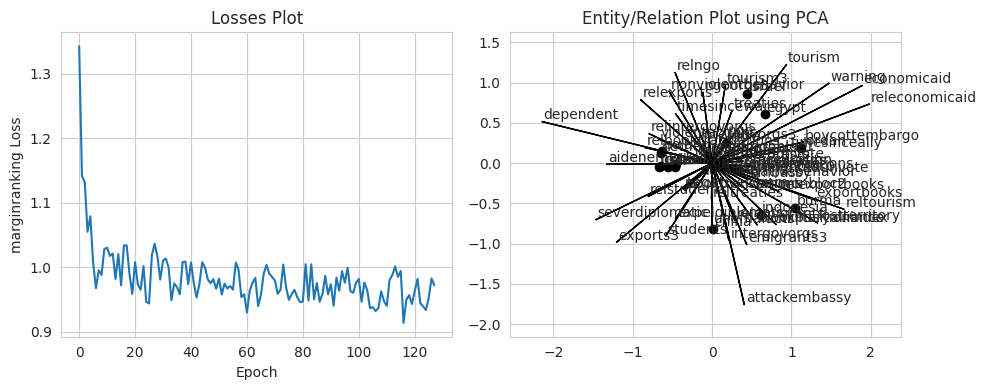

In [10]:
nations_results.plot(
    er_kwargs=dict(
        plot_relations=True,
        plot_entities=True,
        entity_embedding_getter=entity_embedding_getter_TransE,
        relation_embedding_getter=relation_embedding_getter_TransE
    )
)


<AxesSubplot: title={'center': 'Entity/Relation Plot using PCA'}>

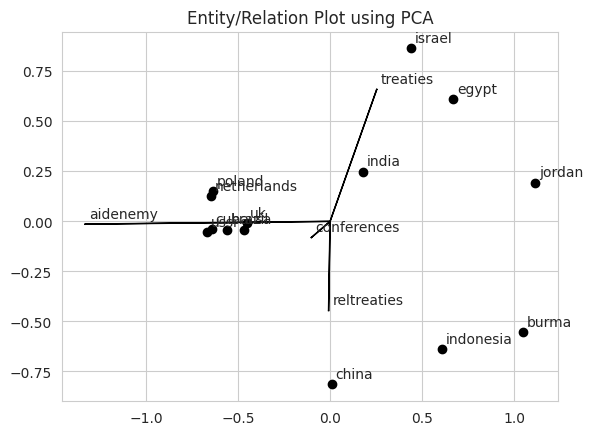

In [25]:
# Filter the ER plot down to a specific set of entities and relations
nations_results.plot_er(
    relations={"reltreaties", "treaties", "conferences", "aidenemy"},
    apply_limits=False,
    plot_relations=True,
    entity_embedding_getter=entity_embedding_getter_TransE,
    relation_embedding_getter=relation_embedding_getter_TransE
)


## Predict

### predict relations

In [33]:
predicted_relations_df = predict.get_prediction_df(
    model=nations_results.model, 
    head_label="usa", 
    tail_label="uk",
    triples_factory=nations_results.training,
)
predicted_relations_df.sort_values(by='score').head()

,relation_id,relation_label,score,in_training
12,12,economicaid,-18.565697,False
2,2,attackembassy,-18.487503,False
53,53,warning,-18.345207,False
15,15,emigrants3,-18.293314,True
10,10,dependent,-18.236172,False


### predict tails

In [34]:
predicted_relations_df = predict.get_prediction_df(
    model=nations_results.model, 
    head_label="china", 
    relation_label="militaryactions",
    triples_factory=nations_results.training,
)
predicted_relations_df.sort_values(by='score').head()

,tail_id,tail_label,score,in_training
11,11,uk,-17.879131,False
4,4,egypt,-17.251577,False
1,1,burma,-17.202198,False
12,12,usa,-17.160477,True
7,7,israel,-16.925850,False


# Toy Example

In [12]:
triples = """
Brussels	locatedIn	Belgium
Belgium	partOf	EU
EU	hasCapital	Brussels
""".strip()

triples = np.array([triple.split("\t") for triple in triples.split("\n")])
tf = TriplesFactory.from_labeled_triples(triples=triples)

INFO:pykeen.pipeline.api:Using device: cpu


Training epochs on cpu:   0%|          | 0/128 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds


(<Figure size 1000x400 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='softplus Loss'>,
        <AxesSubplot: title={'center': 'Entity/Relation Plot'}>],
       dtype=object))

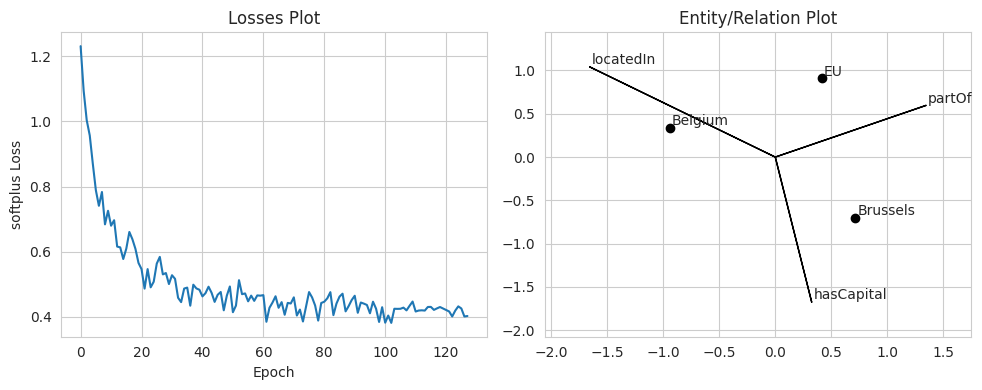

In [15]:
toy_results = pipeline(
    training=tf,
    testing=tf,
    model="TransE",
    loss="softplus",
    model_kwargs=dict(embedding_dim=2),
    optimizer_kwargs=dict(lr=1.0e-1),
    training_kwargs=dict(num_epochs=128, use_tqdm_batch=False),
    evaluation_kwargs=dict(use_tqdm=False),
    random_seed=1,
    device="cpu",
)

toy_results.plot(
    er_kwargs=dict(
        plot_relations=True, 
        entity_embedding_getter=entity_embedding_getter_TransE,
        relation_embedding_getter=relation_embedding_getter_TransE
    )
)


In [37]:
toy_predict_df = predict.get_prediction_df(
    model=toy_results.model,
    head_label="Belgium",
    tail_label="EU",
    triples_factory=tf,
)
toy_predict_df.sort_values(by='score').head()


,relation_id,relation_label,score,in_training
1,1,locatedIn,-3.477479,False
0,0,hasCapital,-3.281689,False
2,2,partOf,-0.033588,True
